In [4]:
from ISP.utils import *
import rawpy
import cv2
import torch

a7r3_raw = rawpy.imread(os.path.join('img', 'CLN00007.ARW')).raw_image_visible

a7r3_srgb = cv2.imread(os.path.join('img', 'CLN00006.JPG'), cv2.IMREAD_COLOR).astype('float32')/255
a7r3_srgb = cv2.cvtColor(a7r3_srgb, cv2.COLOR_BGR2RGB)


black_level = 512
white_level = 15360

img_normalize = torch.from_numpy(a7r3_raw.copy().astype('float32'))
img_normalize = (img_normalize - black_level) / (white_level - black_level)

red = img_normalize[0::2, 0::2]
green_red = img_normalize[0::2, 1::2]
green_blue = img_normalize[1::2, 0::2]
blue = img_normalize[1::2, 1::2]

img_mosaiced = torch.stack([red, green_red, green_blue, blue], dim=2)

wb_r = 2576/1024.0
wb_g = 1.0
wb_b = 1652/1024.0

bayer_pattern = 'RGGB'
# white balance
img_demosaic = WB_img(img_mosaiced, bayer_pattern, wb_r, wb_b) 

# demosaic
demosaic = Demosaic()
img_demosaic = torch.nn.functional.pixel_shuffle(img_demosaic.permute(2, 0, 1).unsqueeze(0), 2)
img_demosaic = demosaic.forward(img_demosaic, pattern=bayer_pattern).squeeze(0).permute(1, 2, 0)

# from Cam to XYZ
# temp_xyz2cam = torch.tensor([6640, -1847, -503, -5238, 13010, 2474, -993, 1673, 6527]).reshape(3,3).float() / 10000
# # Multiplies with RGB -> XYZ to get RGB -> Camera CCM.
# rgb2xyz = torch.tensor([[0.4124564, 0.3575761, 0.1804375],
#                      [0.2126729, 0.7151522, 0.0721750],
#                      [0.0193339, 0.1191920, 0.9503041]])

# rgb2cam = temp_xyz2cam @ rgb2xyz
# rgb2cam = rgb2cam / torch.sum(rgb2cam, dim=-1, keepdims=True)

# temp_cam2xyz = torch.inverse(rgb2cam)

img_IXYZ = apply_cmatrix(img_demosaic, cam2xyz_realblur)

# frome XYZ to linear RGB
img_IL = xyz2lin(img_IXYZ)

# tone mapping
img_Irgb = img_IL
#img_Irgb = lin2rgb_pt(img_IL)
#img_Irgb = lin2rgb_a7r3(img_IL)
img_Irgb = lin2rgb_a7r3_polynomial(img_IL)
img_Irgb = torch.clamp(img_Irgb, 0, 1) # (h, w, c)

cv2.imwrite('img/temp/out.png', img_Irgb[:,:,[2,1,0]].numpy()*255)

True

In [91]:
rgb2cam = torch.from_numpy(xyz2cam_realblur) @ rgb2xyz

In [92]:
rgb2cam.sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000])

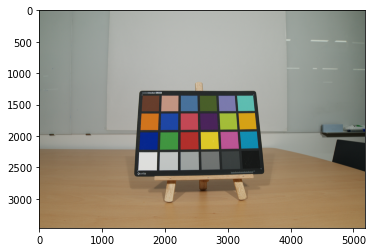

In [56]:
import matplotlib.pyplot as plt
plt.imshow(img_Irgb)

In [50]:
img_demosaic.shape

torch.Size([3464, 5184, 3])